 - combinar las tablas
 - limpiar datos
 - combinar las columnas title, brand, summary, description en una nueva columna
 - tokenizar la nueva columnas combinada
 - calcular similitud con la similitud de los items tokenizados del coseno
 - los que son muy similares los eliminamos de la lista
 - agarramos algunos items de la lista y calculamos el mean del overall
 - ordenamos nuevamente descendentemente pero esta vez basados en el overall mean => lista2
 - recomendamos los 10 primeros de la lista 2



In [3]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
PATH = './AMAZON_FASHION.json.gz'
PATH_meta = './meta_AMAZON_FASHION.json.gz'

In [5]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [6]:
df = getDF(PATH)
df_meta = getDF(PATH_meta)

In [7]:
df_meta.shape

(186637, 16)

In [8]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [9]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 16)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [10]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_metaFrame 'df_meta'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta['combined_text'] = df_meta[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)

Text(0, 0.5, 'Count')

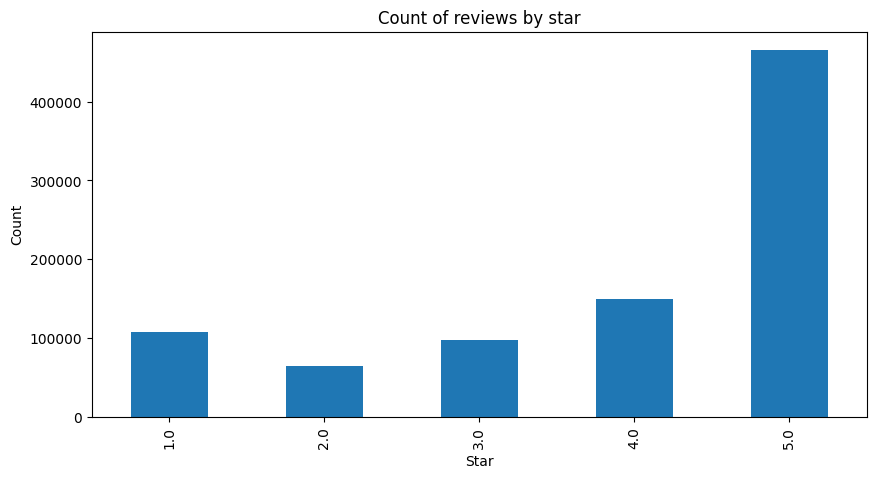

In [11]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")


notamos que los reviews estan sesgados hacia 5 estrellas

calculamos el promedio de estrellas por producto y creamos una nueva columna en el df_metaFrame 'df_meta' para almacenar el promedio de estrellas por producto.

In [12]:
# Calcular el "rating score" promedio por 'asin'
rating_score = df.groupby('asin')['overall'].mean().reset_index()

# Renombrar la columna resultante como 'rating_score'
rating_score.rename(columns={'overall': 'rating_score'}, inplace=True)

# Fusionar el DataFrame original con el "rating score" usando 'asin' como clave
df = df.merge(rating_score, on='asin', how='left')

### Tokenizacion de comentarios

In [13]:
example = df['reviewText'][39]
example

'Excellent product!'

In [14]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Excellent', 'product', '!']

In [15]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [16]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Excellent', 'JJ'), ('product', 'NN'), ('!', '.')]

In [17]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S Excellent/JJ product/NN !/.)


In [18]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,0764443682,5.000000
1,1291691480,5.000000
2,1940280001,5.000000
3,1940735033,4.857143
4,1940967805,5.000000
...,...,...
186184,B01HJGXL4O,5.000000
186185,B01HJGZVYW,4.000000
186186,B01HJH7JY6,5.000000
186187,B01HJHF97K,3.000000


In [19]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos el tama;o total de las muestras a fin de procesar mas rapido

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()


In [21]:
import skfuzzy as fuzz

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
df_meta_cortado = df_meta.head(10000)

In [24]:
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(10000, 22929)

In [25]:
similaridad = cosine_similarity(vecs)
similaridad

array([[1.        , 0.00388052, 0.039671  , ..., 0.00938346, 0.00938346,
        0.00179705],
       [0.00388052, 1.        , 0.        , ..., 0.        , 0.        ,
        0.00467325],
       [0.039671  , 0.        , 1.        , ..., 0.1177269 , 0.1177269 ,
        0.        ],
       ...,
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00179705, 0.00467325, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [26]:
df_meta_cortado.head(2)

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,combined_text,id
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slime Time Fall Fest [With CDROM and Collector...,0
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XCC Qi promise new spider snake preparing men'...,1


In [27]:
def fuzzificar(max, min, valor):
    intervalo = (max - min) / 4

    if valor <= min + intervalo:
        return "pesimo"
    elif valor <= min + 2 * intervalo:
        return "normal"
    elif valor <= min + 3 * intervalo:
        return "bueno"
    else:
        return "excelente"

In [28]:
asin_specific = df_meta_cortado.loc[df_meta_cortado['asin'] == '1291691480']
asin_specific.title.values[0]

"XCC Qi promise new spider snake preparing men's accessories alloy fittings magnet buckle bracelet jewelry"

In [29]:
asin_specific = df_meta_cortado.loc[df_meta_cortado['id'] == 5460]
asin_specific.title.values[0]

'3" Fantasy Spider Necklace Knife'

In [30]:
df.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,rating_score
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,3.823529


In [38]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(similaridad[item_id]))
    sorted_scores = sorted(scores, key=lambda x:x[1], reverse=True)
    # si score es mayor o igual a 1 entonces se elimina de la lista
    scores_no_1 = [i for i in sorted_scores if i[1]<0.8]
    # fuzzificar el score
    scores_no_1 = [(score[0], fuzzificar(scores_no_1[0][1], scores_no_1[-1][1], score[1])) for score in scores_no_1]
    print(scores_no_1)

    # sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in scores_no_1]
    return (items_selected, scores_no_1)

In [40]:
asins, similaridad_score = recommend('1291691480')
print(asins, similaridad_score)

for i in range(2):
    print('Item ID: ',similaridad_score[i][0])
    print('Similarity Score: ',similaridad_score[i][1])
    print('ASIN: ',asins[i])
    print('\n')
    # Busca el 'overall_mean' correspondiente al 'asin'
    overall_mean_item = overall_mean.loc[overall_mean['asin'] == asins[i], 'overall']
    print('Overall Mean: ', overall_mean_item)
    print('\n')

[(3000, 'excelente'), (5460, 'excelente'), (8189, 'excelente'), (7920, 'excelente'), (2252, 'excelente'), (8362, 'bueno'), (8190, 'bueno'), (8191, 'bueno'), (8265, 'bueno'), (7951, 'bueno'), (8161, 'bueno'), (4387, 'bueno'), (4388, 'bueno'), (4386, 'bueno'), (1846, 'bueno'), (4389, 'bueno'), (7923, 'bueno'), (8188, 'bueno'), (8187, 'bueno'), (5675, 'bueno'), (3187, 'bueno'), (7922, 'bueno'), (8702, 'bueno'), (5886, 'bueno'), (2083, 'bueno'), (4844, 'bueno'), (4807, 'bueno'), (9196, 'bueno'), (1017, 'bueno'), (7852, 'bueno'), (3093, 'bueno'), (8777, 'bueno'), (8686, 'bueno'), (8482, 'bueno'), (7467, 'bueno'), (3019, 'bueno'), (2283, 'bueno'), (8701, 'bueno'), (2745, 'bueno'), (8484, 'bueno'), (7119, 'bueno'), (9908, 'bueno'), (6005, 'bueno'), (5660, 'bueno'), (8698, 'bueno'), (4656, 'normal'), (9363, 'normal'), (9365, 'normal'), (9269, 'normal'), (8272, 'normal'), (5378, 'normal'), (4436, 'normal'), (4640, 'normal'), (6673, 'normal'), (4920, 'normal'), (6506, 'normal'), (5150, 'normal')

(0.0, 10000.0)

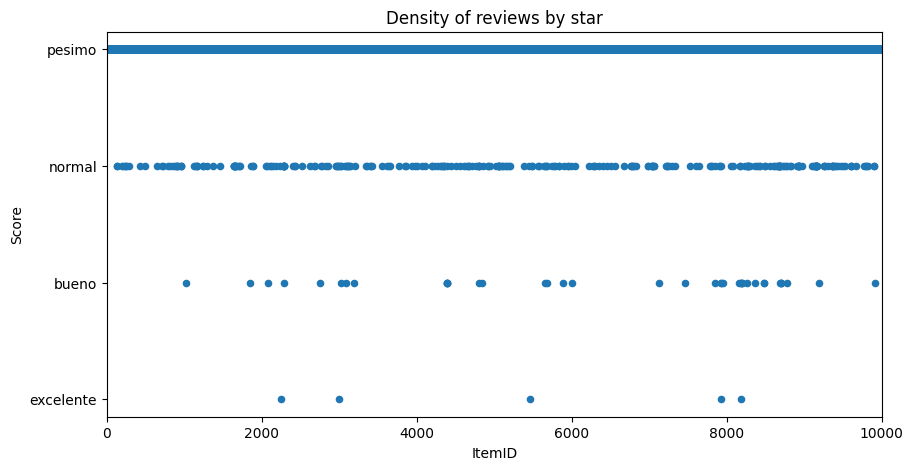

In [41]:
scores_df = pd.DataFrame(similaridad_score, columns=['ItemID', 'Score'])
ax = scores_df.plot.scatter(x='ItemID', y='Score', title="Density of reviews by star", figsize=(10, 5))
ax.set_xlim(0, 10000)

In [42]:
top_100_score = [similaridad_score[i][1] for i in range(100)]
top_100_item_id = [similaridad_score[i][0] for i in range(100)]
top_100_asin = asins[:100]

# Crear una lista de tuplas que contenga el ASIN, el score y el overall en el mismo orden
data = list(zip(top_100_asin, top_100_score, top_100_item_id))

# Crear un DataFrame a partir de los datos combinados
df_result = pd.DataFrame(data, columns=['asin', 'Score', 'Id'])

# Realizar un join entre df_result y result usando la columna 'ASIN' como clave de unión
final_result = pd.merge(df_result, overall_mean, on='asin')

# fuzzificar overall mean
final_result['overall_fuzzificado'] = final_result['overall'].apply(
    lambda valor: fuzzificar(5, 1, valor))

# Imprimir el resultado final
print(final_result)


          asin      Score    Id   overall overall_fuzzificado
0   B000Q4O5CY  excelente  3000  4.000000               bueno
1   B0020WB36G  excelente  5460  3.166667               bueno
2   B004GAK2TE  excelente  8189  4.000000               bueno
3   B004BQJPJ6  excelente  7920  4.000000               bueno
4   B000JFE6TM  excelente  2252  5.000000           excelente
..         ...        ...   ...       ...                 ...
95  B000VYBQF8     normal  3406  5.000000           excelente
96  B00013UWR2     normal   242  2.000000              pesimo
97  B000IZVIBC     normal  2069  4.000000               bueno
98  B004BUW3D2     normal  7927  5.000000           excelente
99  B000CRTITU     normal  1166  3.800000               bueno

[100 rows x 5 columns]


Aplicando fuzzy rules


In [46]:
def fuzzyReglas(similarity_score, overall_mean):
    # Clasificación basada en reglas difusas
    if similarity_score == 'pesimo':
        return 'Not Recommended'
    if overall_mean == 'pesimo':
        return 'Not Recommended'
    
    if similarity_score == 'excelente':
        if overall_mean == 'excelente':
            return 'Highly Recommended'
        elif overall_mean == 'bueno':
            return 'Recommended'
        else: # overall_mean == 'normal'
            return 'Recommended'
    elif similarity_score == 'bueno':
        if overall_mean == 'excelente':
            return 'Highly Recommended'
        elif overall_mean == 'bueno':
            return 'Recommended'
        else: # overall_mean == 'normal'
            return 'Likely Recommended'
    elif similarity_score == 'normal':
        if overall_mean == 'excelente':
            return 'Recommended'
        elif overall_mean == 'bueno':
            return 'Likely Recommended'
        else: # overall_mean == 'normal'
            return 'Not Recommended'



In [47]:
# Aplicar la función fuzzyReglas a cada fila y crear una nueva columna 'result'
final_result['result'] = final_result.apply(lambda row: fuzzyReglas(row['Score'], row['overall_fuzzificado']), axis=1)

# Mostrar el DataFrame resultante
# contar todos los resultados igual a 'Highly Recommended'
print(final_result['result'].value_counts())


result
Recommended           41
Likely Recommended    22
Not Recommended       22
Highly Recommended    15
Name: count, dtype: int64


In [ ]:
# # Realizar un join entre final_result y dataset_original utilizando la columna 'ASIN' como clave de unión
# resultado_completo = pd.merge(final_result, df_meta_cortado, on='asin')

# # Imprimir el resultado completo
# print(resultado_completo)
